<a href="https://colab.research.google.com/github/chaey0/FakeVoice-Detection/blob/main/mfcc_mel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Drive mount & Unzip

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
import zipfile

# 파일 경로 입력
zip_file_name = '/content/drive/MyDrive/DACON/open.zip'

# 압축 해제할 경로 입력
extraction_dir = '/content/dataset'

# 압축 해제
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(extraction_dir)

In [47]:
cd /content/dataset

/content/dataset


## Import

In [1]:
import librosa
import librosa.display



import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import random

from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import torch
#import torchmetrics
import os

In [2]:

import warnings
warnings.filterwarnings('ignore')

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Config

In [4]:
class Config:
    SR = 32000
    N_MFCC = 128
    # Dataset
    ROOT_FOLDER = './'
    # Training
    N_CLASSES = 2
    #BATCH_SIZE = 96
    BATCH_SIZE = 24
    N_EPOCHS = 50
    LR = 0.001

    CLIP_VALUE = 1.0
    # Others
    SEED = 42

CONFIG = Config()

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CONFIG.SEED) # Seed 고정

데이터 2초 단위로 나누기

In [52]:
import soundfile as sf

# CSV 파일 로드
df_train = pd.read_csv('train.csv')
df_test=pd.read_csv('test.csv')


# 데이터 저장을 위한 리스트 초기화
mfcc_data = []
mel_data = []
label_data = []
real_chunks = []
fake_chunks = []


# 라벨 카운트 초기화
label_count = {'real': 0, 'fake': 0, 'combined': 0}

def segment_audio(audio, sample_rate, segment_length=2):
    segment_samples = segment_length * sample_rate
    segments = []
    for i in range(0, len(audio), segment_samples):
        segment = audio[i:i+segment_samples]
        segments.append(segment)
    return segments
'''
def random_pad(mels, pad_size, mfcc=True):
    pad_width = pad_size - mels.shape[1]
    if pad_width <= 0:
        return mels  # 패딩이 필요 없는 경우 원본 배열 반환
    rand = np.random.rand()
    left = int(pad_width * rand)
    right = pad_width - left

    if mfcc:
        mels = np.pad(mels, pad_width=((0, 0), (left, right)), mode='constant')
        local_max, local_min = mels.max(), mels.min()
        mels = (mels - local_min) / (local_max - local_min)
    else:
        local_max, local_min = mels.max(), mels.min()
        mels = (mels - local_min) / (local_max - local_min)
        mels = np.pad(mels, pad_width=((0, 0), (left, right)), mode='constant')

    return mels
    '''
def random_pad(mels, pad_size, mfcc=True):
    pad_width = pad_size - mels.shape[1]
    if pad_width <= 0:
        return mels   # 패딩이 필요 없는 경우 원본 배열 반환
    rand = np.random.rand()
    left = int(pad_width * rand)
    right = pad_width - left

    # Normalize the array
    if mfcc:
        # Pad the array
        mels = np.pad(mels, pad_width=((0, 0), (left, right)), mode='constant')
        local_max, local_min = mels.max(), mels.min()
        mels = (mels - local_min) / (local_max - local_min)
    else:
        local_max, local_min = mels.max(), mels.min()
        if local_max != local_min:  # Avoid division by zero
            mels = (mels - local_min) / (local_max - local_min)
        # Pad the array
        mels = np.pad(mels, pad_width=((0, 0), (left, right)), mode='constant')

    return mels

def add_noise(audio, noise_factor=0.05):
    noise = np.random.randn(len(audio))
    augmented_audio = audio + noise_factor * noise
    augmented_audio = augmented_audio.astype(type(audio[0]))
    return augmented_audio

def overlay_audio(audio_2s, audio_1s, sr):
    #max_offset = len(audio_2s) - len(audio_1s)

    audio_2s = np.pad(audio_2s, (0, int(2.0 * sr) - len(audio_2s)), mode='constant')
    max_offset = len(audio_2s) - len(audio_1s)
    start_position = random.randint(0, max_offset)
    combined_audio = np.copy(audio_2s)
    combined_audio[start_position:start_position+len(audio_1s)] += audio_1s
    return combined_audio

In [8]:
# 데이터셋에서 각 오디오 파일에 대해 처리
for index, row in tqdm(df_train.iterrows()):
    audio_path = row['path']
    label = row['label']

    # 임시
    if label == 'real':
            continue

    # 오디오 파일 로드
    y, sr = librosa.load(audio_path, sr=CONFIG.SR)

    # 오디오 데이터 자르기
    segments = segment_audio(y, sr, segment_length=2)

    for chunk in segments:
        # 노이즈 추가
        if random.random() < 0.5:  # 일정 비율의 오디오에 노이즈 추가
            chunk = add_noise(chunk)

        if label == 'real':
            if len(chunk) < int(1.5 * sr):
                continue  # 1.5초보다 짧은 chunk는 무시
            elif len(chunk) < int(2.0 * sr):
                # 패딩하여 저장
                chunk = np.pad(chunk, (0, int(2.0 * sr) - len(chunk)), mode='constant')
                mfcc = librosa.feature.mfcc(y=chunk, sr=sr, n_mfcc=CONFIG.N_MFCC)
                mels = librosa.feature.melspectrogram(y=chunk, sr=sr, n_mels=CONFIG.N_MFCC)
                mels = librosa.power_to_db(mels, ref=np.max)
                mfcc_data.append(random_pad(mfcc, pad_size=CONFIG.N_MFCC, mfcc=True))
                mel_data.append(random_pad(mels, pad_size=CONFIG.N_MFCC, mfcc=False))
                label_vector = np.zeros(CONFIG.N_CLASSES, dtype=float)
                label_vector[1] = 1
                label_data.append(label_vector)
                label_count['real'] += 1
            else:
                real_chunks.append(chunk)

        elif label == 'fake':
            if len(chunk) < int(1.0 * sr):
                continue  # 1초보다 짧은 chunk는 무시
            else:
                fake_chunks.append(chunk)

                '''
            elif len(chunk) < int(1.5 * sr):
                fake_chunks.append(chunk)
            else:
                # 패딩하여 저장
                chunk = np.pad(chunk, (0, int(2.0 * sr) - len(chunk)), mode='constant')
                mfcc = librosa.feature.mfcc(y=chunk, sr=sr, n_mfcc=CONFIG.N_MFCC)
                mels = librosa.feature.melspectrogram(y=chunk, sr=sr, n_mels=CONFIG.N_MFCC)
                mels = librosa.power_to_db(mels, ref=np.max)
                mfcc_data.append(random_pad(mfcc, pad_size=CONFIG.N_MFCC, mfcc=True))
                mel_data.append(random_pad(mels, pad_size=CONFIG.N_MFCC, mfcc=False))
                label_vector = np.zeros(CONFIG.N_CLASSES, dtype=float)
                label_vector[0] = 1
                label_data.append(label_vector)
                label_count['fake'] += 1
                '''
# Fake chunk 2개를 overlay하여 2초에 맞춰 패딩
for i in tqdm(range(0, len(fake_chunks), 2)):
    if i + 1 >= len(fake_chunks):
        break
    fake_chunk1 = fake_chunks[i]
    fake_chunk2 = fake_chunks[i + 1]
    combined_audio = overlay_audio(fake_chunk1, fake_chunk2, sr)

    # 패딩하여 2초로 맞추기
    if len(combined_audio) < int(2.0 * sr):
        combined_audio = np.pad(combined_audio, (0, int(2.0 * sr) - len(combined_audio)), mode='constant')

       # 노이즈 추가
    if random.random() < 0.5:  # 일정 비율의 오디오에 노이즈 추가
        combined_audio = add_noise(combined_audio)

    # MFCC 추출
    mfcc = librosa.feature.mfcc(y=combined_audio, sr=sr, n_mfcc=CONFIG.N_MFCC)

    # Mel spectrogram 추출
    mels = librosa.feature.melspectrogram(y=combined_audio, sr=sr, n_mels=CONFIG.N_MFCC)
    mels = librosa.power_to_db(mels, ref=np.max)

    # 랜덤 패딩
    pad_size = 128

    # 데이터 저장
    mfcc_data.append(random_pad(mfcc, pad_size=pad_size, mfcc=True))
    mel_data.append(random_pad(mels, pad_size=pad_size, mfcc=False))
    label_vector = np.zeros(CONFIG.N_CLASSES, dtype=float)
    label_vector[0] = 1  # 'fake' label
    label_data.append(label_vector)
    label_count['fake'] += 1

NameError: name 'df_train' is not defined

In [16]:
# Fake 데이터와 Real 데이터를 합성하여 새로운 데이터 생성
for fake_chunk in tqdm(fake_chunks):

    real_chunk = real_chunks.pop(0)  # 순서대로 처리
    combined_audio = overlay_audio(real_chunk, fake_chunk, sr)

    # 노이즈 추가
    if random.random() < 0.5:  # 일정 비율의 오디오에 노이즈 추가
        combined_audio = add_noise(combined_audio)

    # MFCC 추출
    mfcc = librosa.feature.mfcc(y=combined_audio, sr=sr, n_mfcc=CONFIG.N_MFCC)

    # Mel spectrogram 추출
    mels = librosa.feature.melspectrogram(y=combined_audio, sr=sr, n_mels=CONFIG.N_MFCC)
    mels = librosa.power_to_db(mels, ref=np.max)

    # 랜덤 패딩
    pad_size = 128

    # 데이터 저장
    mfcc_data.append(random_pad(mfcc, pad_size=pad_size, mfcc=True))
    mel_data.append(random_pad(mels, pad_size=pad_size, mfcc=False))
    label_vector = np.ones(CONFIG.N_CLASSES, dtype=float)  # [1,1] 레이블
    label_data.append(label_vector)
    label_count['combined'] += 1

# Overlay remaining real data to create new combined data
combined_real_chunks = real_chunks[:30228]
for i in tqdm(range(0, len(combined_real_chunks), 2)):
    if i + 1 >= len(combined_real_chunks):
        break
    real_chunk1 = combined_real_chunks[i]
    real_chunk2 = combined_real_chunks[i + 1]
    combined_audio = overlay_audio(real_chunk1, real_chunk2, sr)

    # 노이즈 추가
    if random.random() < 0.5:  # 일정 비율의 오디오에 노이즈 추가
        combined_audio = add_noise(combined_audio)

    # Extract MFCC features
    mfcc = librosa.feature.mfcc(y=combined_audio, sr=sr, n_mfcc=CONFIG.N_MFCC)

    # Extract Mel spectrogram features
    mels = librosa.feature.melspectrogram(y=combined_audio, sr=sr, n_mels=CONFIG.N_MFCC)
    mels = librosa.power_to_db(mels, ref=np.max)

    # Random padding
    pad_size = 128

    # Save data
    mfcc_data.append(random_pad(mfcc, pad_size=pad_size, mfcc=True))
    mel_data.append(random_pad(mels, pad_size=pad_size, mfcc=False))
    label_vector = np.zeros(CONFIG.N_CLASSES, dtype=float)
    label_vector[1] = 1  # 'real' label
    label_data.append(label_vector)
    label_count['real'] += 1

# Remove used real chunks from the original list
real_chunks = real_chunks[30228:]

# Remaining real chunks 처리하여 저장
for real_chunk in tqdm(real_chunks):
    mfcc = librosa.feature.mfcc(y=real_chunk, sr=sr, n_mfcc=CONFIG.N_MFCC)
    mels = librosa.feature.melspectrogram(y=real_chunk, sr=sr, n_mels=CONFIG.N_MFCC)
    mels = librosa.power_to_db(mels, ref=np.max)
    mfcc_data.append(random_pad(mfcc, pad_size=CONFIG.N_MFCC, mfcc=True))
    mel_data.append(random_pad(mels, pad_size=CONFIG.N_MFCC, mfcc=False))
    label_vector = np.zeros(CONFIG.N_CLASSES, dtype=float)
    label_vector[1] = 1
    label_data.append(label_vector)
    label_count['real'] += 1

100%|██████████| 8380/8380 [04:51<00:00, 28.71it/s]


In [53]:
# MFCC와 Mel spectrogram을 저장할 배열 초기화
test_mfcc_data = []
test_mel_data = []

segment_length=2
sample_rate=32000
segment_samples = segment_length * sample_rate

# 데이터셋에서 각 오디오 파일에 대해 처리
for index, row in tqdm(df_test.iterrows()):
    audio_path = row['path']

    # 오디오 파일 로드
    y, sr = librosa.load(audio_path, sr=CONFIG.SR)

    # 오디오 데이터 자르기
    segments = []

    # 1초부터 샘플링
    for i in range(32000, len(y), segment_samples):
        segment = y[i:i+segment_samples]
        segments.append(segment)

    for chunk in segments:

        # MFCC 추출
        #mfcc = librosa.feature.mfcc(y=chunk, sr=sr, n_mfcc=128)

        # Mel spectrogram 추출
        mels = librosa.feature.melspectrogram(y=chunk, sr=sr, n_mels=128)
        mels=librosa.power_to_db(mels, ref=np.max)

        # 랜덤 패딩
        pad_size = 128

        # 데이터 저장
        #test_mfcc_data.append(random_pad(mfcc, pad_size=pad_size, mfcc=True))
        test_mel_data.append(random_pad(mels, pad_size=pad_size, mfcc=False))


# 리스트를 넘파이 배열로 변환
#test_mfcc_data = np.array(test_mfcc_data)
test_mel_data = np.array(test_mel_data)
print(np.isnan(test_mel_data).any())

50000it [22:44, 36.64it/s]


False


In [85]:
# 리스트를 넘파이 배열로 변환
mfcc_data = np.array(mfcc_data)
mel_data = np.array(mel_data)
label_data = np.array(label_data)

print("MFCC 데이터 형태:", mfcc_data.shape)
print("Mel 스펙트로그램 데이터 형태:", mel_data.shape)
print("라벨 데이터 형태:", label_data.shape)
print("레이블 분포:", label_count)

MFCC 데이터 형태: (0,)
Mel 스펙트로그램 데이터 형태: (0,)
라벨 데이터 형태: (0,)
레이블 분포: {'real': 0, 'fake': 0, 'combined': 0}


In [18]:
np.save('/content/drive/MyDrive/DACON/chunk/aug_mfcc_data.npy',mfcc_data)
np.save('/content/drive/MyDrive/DACON/chunk/aug_mel_data.npy',mel_data)
np.save('/content/drive/MyDrive/DACON/chunk/aug_label_data.npy',label_data)

In [84]:
print(mfcc_data.shape)
print(mel_data.shape)
print(label_data.shape)

AttributeError: 'list' object has no attribute 'shape'

In [6]:
#test_mel_data=np.load('/content/drive/MyDrive/DACON/chunk/test_mel_data.npy')
test_mfcc_data=np.load('/content/drive/MyDrive/DACON/chunk/test_mfcc_data.npy')

print(test_mel_data.shape)
print(test_mfcc_data.shape)
#print(np.isnan(test_mel_data).any())

NameError: name 'test_mel_data' is not defined

In [8]:
#shape 확인
#print(test_mel_data.shape)
print(test_mfcc_data.shape)

#nan 확인
#print(np.isnan(test_mel_data).any())
#print(np.isnan(test_mfcc_data).any())

(100000, 128, 128)


In [21]:
test_mel=np.load('/content/drive/MyDrive/DACON/chunk/test_mel_data.npy')
print(test_mel.shape)

(100000, 128, 128)


In [9]:
mfcc_data=np.load('/content/drive/MyDrive/DACON/chunk/aug_mfcc_data.npy')
#mel_data=np.load('/content/drive/MyDrive/DACON/chunk/aug_mel_data.npy')
label_data=np.load('/content/drive/MyDrive/DACON/chunk/aug_label_data.npy')

print(mfcc_data.shape)
#print(mel_original_data.shape)
print(label_data.shape)

(68585, 128, 128)
(68585, 2)


In [71]:
#check nan
print(np.isnan(mfcc_original_data).any())
print(np.isnan(mel_original_data).any())
print(np.isnan(label_original_data).any())

False
False
False


In [8]:
mfcc_data = np.concatenate((mfcc_data, mfcc_original_data), axis=0)
mel_data = np.concatenate((mel_data, mel_original_data), axis=0)
label_data = np.concatenate((label_data, label_original_data), axis=0)

print(mfcc_data.shape)
print(mel_data.shape)
print(label_data.shape)

NameError: name 'mfcc_data' is not defined

In [10]:
mfcc_data=mfcc_original_data
mel_data=mel_original_data
label_data=label_original_data

In [10]:
np.save('/content/drive/MyDrive/DACON/chunk/aug_mfcc_data.npy',mfcc_data)
np.save('/content/drive/MyDrive/DACON/chunk/aug_mel_data.npy',mel_data)
np.save('/content/drive/MyDrive/DACON/chunk/aug_label_data.npy',label_data)

## 라벨 분포 확인

Label distribution:
[0. 1.]: 30473
[1. 0.]: 28063
[1. 1.]: 10049


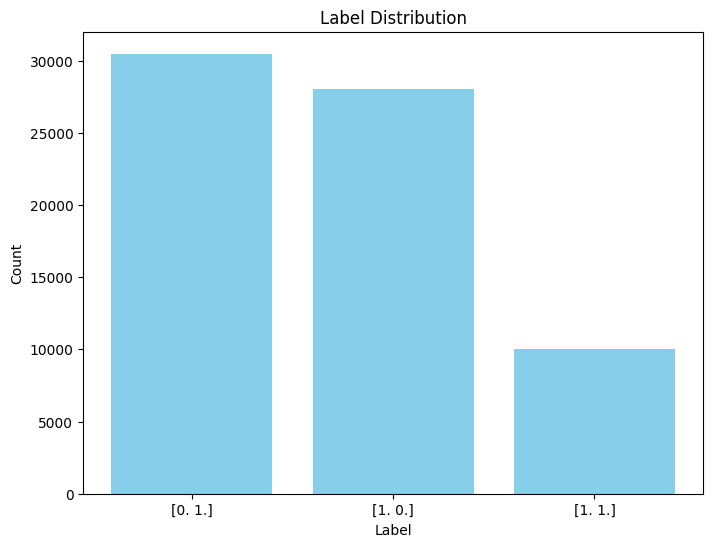

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 라벨 분포 확인
unique, counts = np.unique(label_data, axis=0, return_counts=True)
label_counts = {str(label): count for label, count in zip(unique, counts)}

# 출력
print("Label distribution:")
for label, count in label_counts.items():
    print(f"{label}: {count}")

# 라벨 분포를 시각화
labels = [str(label) for label in unique]
counts = counts

plt.figure(figsize=(8, 6))
plt.bar(labels, counts, color='skyblue')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.show()


In [11]:
# new label - label 균형

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample

# 라벨 분포 확인
unique, counts = np.unique(label_data, axis=0, return_counts=True)
label_counts = {str(label): count for label, count in zip(unique, counts)}

# 출력
print("Label distribution:")
for label, count in label_counts.items():
    print(f"{label}: {count}")

# 클래스별 데이터 인덱스 추출
class_01_idx = np.where((label_data == [0, 1]).all(axis=1))[0]
class_10_idx = np.where((label_data == [1, 0]).all(axis=1))[0]
class_11_idx = np.where((label_data == [1, 1]).all(axis=1))[0]

# 소수 클래스의 샘플 수 확인
min_class_samples = len(class_10_idx)

# 초반 10049개 제외
class_01_idx_to_use = class_01_idx[10049:]

# 다수 클래스에서 소수 클래스 샘플 수만큼 랜덤 샘플링
class_01_sampled_idx = np.random.choice(class_01_idx_to_use, min_class_samples)

# 새로운 데이터셋 생성
new_indices = np.concatenate([class_01_sampled_idx, class_10_idx, class_11_idx])
np.random.shuffle(new_indices)  # 섞기

# 데이터셋 추출
new_mel_data = mel_data[new_indices]
new_mfcc_data = mfcc_data[new_indices]
new_label_data = label_data[new_indices]

# 남은 [0, 1] 인덱스 추출
remaining_class_01_idx = np.setdiff1d(class_01_idx, class_01_sampled_idx)

# 새로운 라벨 분포 확인
new_unique, new_counts = np.unique(new_label_data, axis=0, return_counts=True)
new_label_counts = {str(label): count for label, count in zip(new_unique, new_counts)}

# 출력
print("\nNew label distribution:")
for label, count in new_label_counts.items():
    print(f"{label}: {count}")

# 새로운 라벨 분포를 시각화
new_labels = [str(label) for label in new_unique]
new_counts = new_counts

plt.figure(figsize=(8, 6))
plt.bar(new_labels, new_counts, color='skyblue')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('New Label Distribution')
plt.show()


Label distribution:
[0. 1.]: 30473
[1. 0.]: 28063
[1. 1.]: 10049


NameError: name 'mel_data' is not defined

In [12]:
print(new_mel_data.shape)
print(new_mfcc_data.shape)

print(new_label_data.shape)
print(new_label_data[0])

#check for NAN values
print(np.isnan(new_mel_data).any())
print(np.isnan(new_mfcc_data).any())
print(np.isnan(new_label_data).any())

(66175, 128, 128)
(66175, 128, 128)
(66175, 2)
[0. 1.]
False
False
False


In [13]:
mel_data=new_mel_data
mfcc_data=new_mfcc_data
label_data=new_label_data

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimplifiedCNNMultiLabel(nn.Module):
    def __init__(self, in_channels=1, num_classes=2):
        super(SimplifiedCNNMultiLabel, self).__init__()

        self.features = nn.Sequential(
            self._conv_block(in_channels, 32),
            nn.MaxPool2d(2),
            self._conv_block(32, 64),
            nn.MaxPool2d(2),
            self._conv_block(64, 128),
            nn.MaxPool2d(2),
            self._conv_block(128, 256),
            nn.AdaptiveAvgPool2d(1)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def _conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    # sigmoid 제거
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return x

In [12]:

import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=1, stride=1, padding=0)
        self.bn2 = nn.BatchNorm2d(in_channels)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(in_channels)
        self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.shortcut = nn.Sequential()

        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        shortcut = self.shortcut(x)
        x = F.relu(self.bn1(x))
        x = F.relu(self.bn2(self.conv1(x)))
        x = F.relu(self.bn3(self.conv2(x)))
        x = self.conv3(x)
        x += shortcut
        return F.relu(x)

class ResCNN(nn.Module):
    def __init__(self):
        super(ResCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.residual_block1 = ResidualBlock(16, 32)
        self.residual_block2 = ResidualBlock(32, 32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.residual_block3 = ResidualBlock(32, 64)
        self.residual_block4 = ResidualBlock(64, 64)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.residual_block5 = ResidualBlock(64, 128)
        self.residual_block6 = ResidualBlock(128, 128)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc1 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)

        x = self.residual_block1(x)
        x = self.residual_block2(x)
        x = self.pool2(x)

        x = self.residual_block3(x)
        x = self.residual_block4(x)
        x = self.pool3(x)

        x = self.residual_block5(x)
        x = self.residual_block6(x)
        x = self.pool4(x)

        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)  # Flatten

        x = F.relu(self.bn2(self.fc1(x)))
        x = self.dropout1(x)
        x = self.fc2(x)

        return x

In [33]:
from torchinfo import summary

model = ResCNN()
summary(model, input_size=(1, 1,128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
ResCNN                                   [1, 2]                    --
├─Conv2d: 1-1                            [1, 16, 128, 128]         160
├─BatchNorm2d: 1-2                       [1, 16, 128, 128]         32
├─MaxPool2d: 1-3                         [1, 16, 64, 64]           --
├─ResidualBlock: 1-4                     [1, 32, 64, 64]           --
│    └─Sequential: 2-1                   [1, 32, 64, 64]           --
│    │    └─Conv2d: 3-1                  [1, 32, 64, 64]           544
│    │    └─BatchNorm2d: 3-2             [1, 32, 64, 64]           64
│    └─BatchNorm2d: 2-2                  [1, 16, 64, 64]           32
│    └─Conv2d: 2-3                       [1, 16, 64, 64]           272
│    └─BatchNorm2d: 2-4                  [1, 16, 64, 64]           32
│    └─Conv2d: 2-5                       [1, 16, 64, 64]           2,320
│    └─BatchNorm2d: 2-6                  [1, 16, 64, 64]           32
│    └─Co

In [13]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduce = reduce

    def forward(self, inputs
                , targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [14]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=CONFIG.N_EPOCHS):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    best_model = None
    best_hamming_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0.0

        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()

            optimizer.step()
            epoch_train_loss += loss.item() * inputs.size(0)

        epoch_train_loss /= len(train_loader.dataset)

        # Validation
        model.eval()
        val_preds = []
        val_labels = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_preds.extend(outputs.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        # Apply threshold to predictions
        val_preds = (np.array(val_preds) > 0.5).astype(int)
        val_labels = np.array(val_labels)

        hamming_loss_val = hamming_loss(val_labels, val_preds)
        subset_accuracy_val = accuracy_score(val_labels, val_preds, normalize=True, sample_weight=None)

        print(f"Epoch {epoch + 1}/{num_epochs}, "
              f"Train Loss: {epoch_train_loss:.4f}, "
              f"Val Hamming Loss: {hamming_loss_val:.4f}, "
              f"Val Subset Accuracy: {subset_accuracy_val:.4f}")

        # Update best model if current Hamming loss is better
        if hamming_loss_val < best_hamming_loss:
            best_hamming_loss = hamming_loss_val
            best_model = model.state_dict()

    # Load best model
    model.load_state_dict(best_model)

    return model, best_hamming_loss

In [15]:
# Function to predict on multiple segments and aggregate results
def prediction(model, test_mfcc_data, device):
    model.eval()
    preds_list = []
    with torch.no_grad():
        for i in range(0, len(test_mfcc_data), 2):
            data_1 = test_mfcc_data[i]
            data_2 = test_mfcc_data[i + 1]

            inputs_1 = torch.Tensor(data_1).unsqueeze(0).unsqueeze(0).to(device)  # Assuming segment shape is (1, 1, segment_length)
            inputs_2 = torch.Tensor(data_2).unsqueeze(0).unsqueeze(0).to(device)

            preds_1 = model(inputs_1)
            preds_2 = model(inputs_2)

            preds_1=torch.sigmoid(preds_1).cpu().detach().numpy()
            preds_2=torch.sigmoid(preds_2).cpu().detach().numpy()

            # Take the average of predictions
            preds_avg = (preds_1 + preds_2) / 2.0
            preds_list.append(preds_avg)

    return preds_list


In [24]:
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import hamming_loss, accuracy_score

# Iterate over folds
from sklearn.model_selection import StratifiedKFold

#pred_list_mel = []  # Store predictions for Mel model
pred_list_mfcc = []  # Store predictions for MFCC model

# StratifiedKFold 객체 생성
n_splits = 5  # 원하는 폴드 수
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

for fold, (train_index, val_index) in enumerate(skf.split(mfcc_data, np.argmax(label_data, axis=1))):
    print(f'\n********** {fold+1} fold **********')
    '''
    # Mel spectrogram model
    #model_mel = SimplifiedCNNMultiLabel()
    model_mel = ResCNN()

    x_train_mel, x_val_mel = mel_data[train_index], mel_data[val_index]
    y_train_mel, y_val_mel = label_data[train_index], label_data[val_index]

    train_dataset_mel = TensorDataset(torch.Tensor(x_train_mel).unsqueeze(1), torch.Tensor(y_train_mel))
    val_dataset_mel = TensorDataset(torch.Tensor(x_val_mel).unsqueeze(1), torch.Tensor(y_val_mel))

    train_loader_mel = DataLoader(train_dataset_mel, batch_size=CONFIG.BATCH_SIZE, shuffle=True)
    val_loader_mel = DataLoader(val_dataset_mel, batch_size=CONFIG.BATCH_SIZE)

    criterion_mel = FocalLoss()
    optimizer_mel = optim.Adam(model_mel.parameters(), lr=CONFIG.LR)

    # Train Mel spectrogram model
    #model_mel, best_auc_mel = train_model(model_mel, train_loader_mel, val_loader_mel, criterion_mel, optimizer_mel)
    model_mel, best_hamming_loss = train_model(model_mel, train_loader_mel, val_loader_mel, criterion_mel, optimizer_mel)

    # 모델 저장
    save_dir='/content/drive/MyDrive/DACON/chunk/mel_models'
    model_path = os.path.join(save_dir, f'rescnn_fold{fold}_best.pth')
    torch.save(model_mel.state_dict(), model_path)

    # Validation on full 5-second validation data for Mel model
    model_mel.eval()
    val_preds_mel = []
    val_labels_mel = []

    batch_size = CONFIG.BATCH_SIZE
    with torch.no_grad():
        for i in range(0, len(x_val_mel), batch_size):
            inputs = torch.Tensor(x_val_mel[i:i+batch_size]).to(device).unsqueeze(1)
            outputs = model_mel(inputs)
            #val_preds_mel.extend(outputs.cpu().numpy())
            val_preds_mel.extend((outputs.cpu().numpy() > 0.5).astype(int))
            val_labels_mel.extend(y_val_mel[i:i+batch_size])

    val_preds_mel = np.array(val_preds_mel)
    val_labels_mel = np.array(val_labels_mel)
    #auc_mel = roc_auc_score(val_labels_mel, val_preds_mel, average='weighted')
    hamming_loss_mel = hamming_loss(val_labels_mel, val_preds_mel)
    subset_accuracy_mel = accuracy_score(val_labels_mel, val_preds_mel, normalize=True, sample_weight=None)

    #print(f'mels_model_auc : {auc_mel:.4f}')
    print(f'mels_model_hamming_loss : {hamming_loss_mel:.4f}')
    print(f'mels_model_subset_accuracy : {subset_accuracy_mel:.4f}')

    # Store predictions on test data for Mel model
    preds_test_mel = prediction(model_mel, test_mel_data, device)
    pred_list_mel.append(preds_test_mel)
    '''

    # MFCC model
    #model_mfcc = SimplifiedCNNMultiLabel()
    model_mfcc = ResCNN()

    x_train_mfcc, x_val_mfcc = mfcc_data[train_index], mfcc_data[val_index]
    y_train_mfcc, y_val_mfcc = label_data[train_index], label_data[val_index]

    train_dataset_mfcc = TensorDataset(torch.Tensor(x_train_mfcc).unsqueeze(1), torch.Tensor(y_train_mfcc))
    val_dataset_mfcc = TensorDataset(torch.Tensor(x_val_mfcc).unsqueeze(1), torch.Tensor(y_val_mfcc))
    train_loader_mfcc = DataLoader(train_dataset_mfcc, batch_size=CONFIG.BATCH_SIZE, shuffle=True)
    val_loader_mfcc = DataLoader(val_dataset_mfcc, batch_size=CONFIG.BATCH_SIZE)

    optimizer_mfcc = optim.Adam(model_mfcc.parameters(), lr=CONFIG.LR)
    #criterion_mfcc = FocalLoss()
    criterion_mfcc = nn.BCEWithLogitsLoss()

    # Train MFCC model
    #model_mfcc, best_auc_mfcc = train_model(model_mfcc, train_loader_mfcc, val_loader_mfcc, criterion_mfcc, optimizer_mfcc)
    model_mfcc, best_hamming_loss = train_model(model_mfcc, train_loader_mfcc, val_loader_mfcc, criterion_mfcc, optimizer_mfcc)

    # 모델 저장
    save_dir='/content/drive/MyDrive/DACON/chunk/mfcc_models'
    model_path = os.path.join(save_dir, f'rescnn_fold{fold}_best.pth')
    torch.save(model_mfcc.state_dict(), model_path)

    # Validation on full 5-second validation data for MFCC model
    model_mfcc.eval()
    val_preds_mfcc = []
    val_labels_mfcc = []

    batch_size = CONFIG.BATCH_SIZE
    with torch.no_grad():
        for i in range(0, len(x_val_mfcc), batch_size):
            inputs = torch.Tensor(x_val_mfcc[i:i+batch_size]).to(device).unsqueeze(1)
            outputs = model_mfcc(inputs)
            #val_preds_mfcc.extend(outputs.cpu().numpy())
            val_preds_mfcc.extend((outputs.cpu().numpy() > 0.5).astype(int))
            val_labels_mfcc.extend(y_val_mfcc[i:i+batch_size])

    val_preds_mfcc = np.array(val_preds_mfcc)
    val_labels_mfcc = np.array(val_labels_mfcc)
    #auc_mfcc = roc_auc_score(val_labels_mfcc, val_preds_mfcc, average='weighted')

    hamming_loss_mfcc = hamming_loss(val_labels_mfcc, val_preds_mfcc)
    subset_accuracy_mfcc = accuracy_score(val_labels_mfcc, val_preds_mfcc, normalize=True, sample_weight=None)

    #print(f'mfcc_model_auc : {auc_mfcc:.4f}')
    print(f'mfcc_model_hamming_loss : {hamming_loss_mfcc:.4f}')
    print(f'mfcc_model_subset_accuracy : {subset_accuracy_mfcc:.4f}')

    # Store predictions on test data for MFCC model
    preds_test_mfcc = prediction(model_mfcc, test_mfcc_data, device)
    pred_list_mfcc.append(preds_test_mfcc)

    # Print fold ensemble metrics if needed
    print(f'Ensemble metrics for fold {fold+1}')

# Calculate mean predictions from all folds
#pred_mean_mel = np.mean(pred_list_mel, axis=0)
pred_mean_mfcc = np.mean(pred_list_mfcc, axis=0)

# Perform final ensemble by averaging predictions
#final_pred_mean = (pred_mean_mel + pred_mean_mfcc) / 2.0


********** 1 fold **********


Epoch 1/50: 100%|██████████| 2287/2287 [00:34<00:00, 66.40it/s]


Epoch 1/50, Train Loss: 0.3590, Val Hamming Loss: 0.1416, Val Subset Accuracy: 0.7914


Epoch 2/50: 100%|██████████| 2287/2287 [00:34<00:00, 67.21it/s]


Epoch 2/50, Train Loss: 0.2279, Val Hamming Loss: 0.0946, Val Subset Accuracy: 0.8541


Epoch 3/50: 100%|██████████| 2287/2287 [00:34<00:00, 66.12it/s]


Epoch 3/50, Train Loss: 0.1904, Val Hamming Loss: 0.2330, Val Subset Accuracy: 0.6854


Epoch 4/50:  88%|████████▊ | 2008/2287 [00:30<00:04, 66.21it/s]


KeyboardInterrupt: 

In [43]:
'''
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import hamming_loss, accuracy_score

# Perform a single train-validation split
train_index, val_index = train_test_split(np.arange(len(mel_data)), test_size=0.2, stratify=np.argmax(label_data, axis=1), random_state=CONFIG.SEED)

# Mel spectrogram model
model_mel = SimplifiedCNNMultiLabel()

x_train_mel, x_val_mel = mel_data[train_index], mel_data[val_index]
y_train_mel, y_val_mel = label_data[train_index], label_data[val_index]

train_dataset_mel = TensorDataset(torch.Tensor(x_train_mel).unsqueeze(1), torch.Tensor(y_train_mel))
val_dataset_mel = TensorDataset(torch.Tensor(x_val_mel).unsqueeze(1), torch.Tensor(y_val_mel))

train_loader_mel = DataLoader(train_dataset_mel, batch_size=CONFIG.BATCH_SIZE, shuffle=True)
val_loader_mel = DataLoader(val_dataset_mel, batch_size=CONFIG.BATCH_SIZE)

criterion_mel = FocalLoss()
optimizer_mel = optim.Adam(model_mel.parameters(), lr=CONFIG.LR)

# Train Mel spectrogram model
#model_mel, best_auc_mel = train_model(model_mel, train_loader_mel, val_loader_mel, criterion_mel, optimizer_mel)
model_mel, best_hamming_loss = train_model(model_mel, train_loader_mel, val_loader_mel, criterion_mel, optimizer_mel)

# Validation on full 5-second validation data for Mel model
model_mel.eval()
val_preds_mel = []
val_labels_mel = []

batch_size = CONFIG.BATCH_SIZE
with torch.no_grad():
    for i in range(0, len(x_val_mel), batch_size):
        inputs = torch.Tensor(x_val_mel[i:i+batch_size]).to(device).unsqueeze(1)
        outputs = model_mel(inputs)
        #val_preds_mel.extend(outputs.cpu().numpy())
        val_preds_mel.extend((outputs.cpu().numpy() > 0.5).astype(int))
        val_labels_mel.extend(y_val_mel[i:i+batch_size])

val_preds_mel = np.array(val_preds_mel)
val_labels_mel = np.array(val_labels_mel)
#auc_mel = roc_auc_score(val_labels_mel, val_preds_mel, average='weighted')
hamming_loss_mel = hamming_loss(val_labels_mel, val_preds_mel)
subset_accuracy_mel = accuracy_score(val_labels_mel, val_preds_mel, normalize=True, sample_weight=None)


#print(f'mels_model_auc : {auc_mel:.4f}')
print(f'mels_model_hamming_loss : {hamming_loss_mel:.4f}')
print(f'mels_model_subset_accuracy : {subset_accuracy_mel:.4f}')

# MFCC model
model_mfcc = SimplifiedCNNMultiLabel()

x_train_mfcc, x_val_mfcc = mfcc_data[train_index], mfcc_data[val_index]
y_train_mfcc, y_val_mfcc = label_data[train_index], label_data[val_index]

train_dataset_mfcc = TensorDataset(torch.Tensor(x_train_mfcc).unsqueeze(1), torch.Tensor(y_train_mfcc))
val_dataset_mfcc = TensorDataset(torch.Tensor(x_val_mfcc).unsqueeze(1), torch.Tensor(y_val_mfcc))
train_loader_mfcc = DataLoader(train_dataset_mfcc, batch_size=CONFIG.BATCH_SIZE, shuffle=True)
val_loader_mfcc = DataLoader(val_dataset_mfcc, batch_size=CONFIG.BATCH_SIZE)

optimizer_mfcc = optim.Adam(model_mfcc.parameters(), lr=CONFIG.LR)
criterion_mfcc = FocalLoss()

# Train MFCC model
#model_mfcc, best_auc_mfcc = train_model(model_mfcc, train_loader_mfcc, val_loader_mfcc, criterion_mfcc, optimizer_mfcc)
model_mfcc, best_hamming_loss = train_model(model_mfcc, train_loader_mfcc, val_loader_mfcc, criterion_mfcc, optimizer_mfcc)


# Validation on full 5-second validation data for MFCC model
model_mfcc.eval()
val_preds_mfcc = []
val_labels_mfcc = []

batch_size = CONFIG.BATCH_SIZE
with torch.no_grad():
    for i in range(0, len(x_val_mfcc), batch_size):
        inputs = torch.Tensor(x_val_mfcc[i:i+batch_size]).to(device).unsqueeze(1)
        outputs = model_mfcc(inputs)
        #val_preds_mfcc.extend(outputs.cpu().numpy())
        val_preds_mfcc.extend((outputs.cpu().numpy() > 0.5).astype(int))
        val_labels_mfcc.extend(y_val_mfcc[i:i+batch_size])

val_preds_mfcc = np.array(val_preds_mfcc)
val_labels_mfcc = np.array(val_labels_mfcc)
#auc_mfcc = roc_auc_score(val_labels_mfcc, val_preds_mfcc, average='weighted')

hamming_loss_mfcc = hamming_loss(val_labels_mfcc, val_preds_mfcc)
subset_accuracy_mfcc = accuracy_score(val_labels_mfcc, val_preds_mfcc, normalize=True, sample_weight=None)

#print(f'mfcc_model_auc : {auc_mfcc:.4f}')
print(f'mfcc_model_hamming_loss : {hamming_loss_mfcc:.4f}')
print(f'mfcc_model_subset_accuracy : {subset_accuracy_mfcc:.4f}')
'''


Epoch 1/20: 100%|██████████| 572/572 [01:32<00:00,  6.20it/s]


Epoch 1/20, Train Loss: 0.0697, Val Hamming Loss: 0.1137, Val Subset Accuracy: 0.8010


Epoch 2/20: 100%|██████████| 572/572 [01:32<00:00,  6.20it/s]


Epoch 2/20, Train Loss: 0.0366, Val Hamming Loss: 0.2487, Val Subset Accuracy: 0.6608


Epoch 3/20: 100%|██████████| 572/572 [01:32<00:00,  6.19it/s]


Epoch 3/20, Train Loss: 0.0272, Val Hamming Loss: 0.0418, Val Subset Accuracy: 0.9278


Epoch 4/20: 100%|██████████| 572/572 [01:32<00:00,  6.19it/s]


Epoch 4/20, Train Loss: 0.0217, Val Hamming Loss: 0.0375, Val Subset Accuracy: 0.9329


Epoch 5/20: 100%|██████████| 572/572 [01:32<00:00,  6.18it/s]


Epoch 5/20, Train Loss: 0.0194, Val Hamming Loss: 0.0779, Val Subset Accuracy: 0.8650


Epoch 6/20: 100%|██████████| 572/572 [01:32<00:00,  6.19it/s]


Epoch 6/20, Train Loss: 0.0165, Val Hamming Loss: 0.1092, Val Subset Accuracy: 0.8148


Epoch 7/20: 100%|██████████| 572/572 [01:32<00:00,  6.19it/s]


Epoch 7/20, Train Loss: 0.0136, Val Hamming Loss: 0.2165, Val Subset Accuracy: 0.6999


Epoch 8/20: 100%|██████████| 572/572 [01:32<00:00,  6.19it/s]


Epoch 8/20, Train Loss: 0.0131, Val Hamming Loss: 0.1645, Val Subset Accuracy: 0.7413


Epoch 9/20: 100%|██████████| 572/572 [01:32<00:00,  6.18it/s]


Epoch 9/20, Train Loss: 0.0113, Val Hamming Loss: 0.0609, Val Subset Accuracy: 0.8925


Epoch 10/20: 100%|██████████| 572/572 [01:32<00:00,  6.18it/s]


Epoch 10/20, Train Loss: 0.0105, Val Hamming Loss: 0.0193, Val Subset Accuracy: 0.9652


Epoch 11/20: 100%|██████████| 572/572 [01:32<00:00,  6.19it/s]


Epoch 11/20, Train Loss: 0.0085, Val Hamming Loss: 0.0483, Val Subset Accuracy: 0.9157


Epoch 12/20: 100%|██████████| 572/572 [01:32<00:00,  6.19it/s]


Epoch 12/20, Train Loss: 0.0088, Val Hamming Loss: 0.0313, Val Subset Accuracy: 0.9463


Epoch 13/20: 100%|██████████| 572/572 [01:32<00:00,  6.18it/s]


Epoch 13/20, Train Loss: 0.0071, Val Hamming Loss: 0.0377, Val Subset Accuracy: 0.9350


Epoch 14/20: 100%|██████████| 572/572 [01:32<00:00,  6.19it/s]


Epoch 14/20, Train Loss: 0.0071, Val Hamming Loss: 0.0422, Val Subset Accuracy: 0.9277


Epoch 15/20: 100%|██████████| 572/572 [01:32<00:00,  6.19it/s]


Epoch 15/20, Train Loss: 0.0069, Val Hamming Loss: 0.0528, Val Subset Accuracy: 0.9103


Epoch 16/20: 100%|██████████| 572/572 [01:32<00:00,  6.18it/s]


Epoch 16/20, Train Loss: 0.0052, Val Hamming Loss: 0.0243, Val Subset Accuracy: 0.9579


Epoch 17/20: 100%|██████████| 572/572 [01:32<00:00,  6.19it/s]


Epoch 17/20, Train Loss: 0.0064, Val Hamming Loss: 0.0151, Val Subset Accuracy: 0.9719


Epoch 18/20: 100%|██████████| 572/572 [01:32<00:00,  6.19it/s]


Epoch 18/20, Train Loss: 0.0043, Val Hamming Loss: 0.0151, Val Subset Accuracy: 0.9726


Epoch 19/20: 100%|██████████| 572/572 [01:32<00:00,  6.19it/s]


Epoch 19/20, Train Loss: 0.0050, Val Hamming Loss: 0.0464, Val Subset Accuracy: 0.9213


Epoch 20/20: 100%|██████████| 572/572 [01:32<00:00,  6.19it/s]


Epoch 20/20, Train Loss: 0.0046, Val Hamming Loss: 0.1230, Val Subset Accuracy: 0.8165
mels_model_hamming_loss : 0.1230
mels_model_subset_accuracy : 0.8165


Epoch 1/20: 100%|██████████| 572/572 [01:32<00:00,  6.21it/s]


Epoch 1/20, Train Loss: 0.1051, Val Hamming Loss: 0.2161, Val Subset Accuracy: 0.6336


Epoch 2/20: 100%|██████████| 572/572 [01:32<00:00,  6.19it/s]


Epoch 2/20, Train Loss: 0.0594, Val Hamming Loss: 0.1437, Val Subset Accuracy: 0.7612


Epoch 3/20: 100%|██████████| 572/572 [01:32<00:00,  6.20it/s]


Epoch 3/20, Train Loss: 0.0462, Val Hamming Loss: 0.0795, Val Subset Accuracy: 0.8558


Epoch 4/20: 100%|██████████| 572/572 [01:32<00:00,  6.19it/s]


Epoch 4/20, Train Loss: 0.0366, Val Hamming Loss: 0.0562, Val Subset Accuracy: 0.9041


Epoch 5/20: 100%|██████████| 572/572 [01:32<00:00,  6.19it/s]


Epoch 5/20, Train Loss: 0.0309, Val Hamming Loss: 0.0734, Val Subset Accuracy: 0.8705


Epoch 6/20: 100%|██████████| 572/572 [01:32<00:00,  6.18it/s]


Epoch 6/20, Train Loss: 0.0269, Val Hamming Loss: 0.0708, Val Subset Accuracy: 0.8778


Epoch 7/20: 100%|██████████| 572/572 [01:32<00:00,  6.19it/s]


Epoch 7/20, Train Loss: 0.0228, Val Hamming Loss: 0.0943, Val Subset Accuracy: 0.8401


Epoch 8/20: 100%|██████████| 572/572 [01:32<00:00,  6.18it/s]


Epoch 8/20, Train Loss: 0.0208, Val Hamming Loss: 0.0683, Val Subset Accuracy: 0.8856


Epoch 9/20: 100%|██████████| 572/572 [01:32<00:00,  6.18it/s]


Epoch 9/20, Train Loss: 0.0179, Val Hamming Loss: 0.1417, Val Subset Accuracy: 0.7962


Epoch 10/20: 100%|██████████| 572/572 [01:32<00:00,  6.18it/s]


Epoch 10/20, Train Loss: 0.0162, Val Hamming Loss: 0.0818, Val Subset Accuracy: 0.8720


Epoch 11/20: 100%|██████████| 572/572 [01:32<00:00,  6.18it/s]


Epoch 11/20, Train Loss: 0.0154, Val Hamming Loss: 0.0391, Val Subset Accuracy: 0.9318


Epoch 12/20: 100%|██████████| 572/572 [01:32<00:00,  6.18it/s]


Epoch 12/20, Train Loss: 0.0133, Val Hamming Loss: 0.0502, Val Subset Accuracy: 0.9116


Epoch 13/20: 100%|██████████| 572/572 [01:32<00:00,  6.18it/s]


Epoch 13/20, Train Loss: 0.0116, Val Hamming Loss: 0.0281, Val Subset Accuracy: 0.9517


Epoch 14/20: 100%|██████████| 572/572 [01:32<00:00,  6.19it/s]


Epoch 14/20, Train Loss: 0.0115, Val Hamming Loss: 0.0338, Val Subset Accuracy: 0.9399


Epoch 15/20: 100%|██████████| 572/572 [01:32<00:00,  6.19it/s]


Epoch 15/20, Train Loss: 0.0099, Val Hamming Loss: 0.0494, Val Subset Accuracy: 0.9175


Epoch 16/20: 100%|██████████| 572/572 [01:32<00:00,  6.18it/s]


Epoch 16/20, Train Loss: 0.0097, Val Hamming Loss: 0.0519, Val Subset Accuracy: 0.9053


Epoch 17/20: 100%|██████████| 572/572 [01:32<00:00,  6.18it/s]


Epoch 17/20, Train Loss: 0.0090, Val Hamming Loss: 0.0512, Val Subset Accuracy: 0.9130


Epoch 18/20: 100%|██████████| 572/572 [01:32<00:00,  6.18it/s]


Epoch 18/20, Train Loss: 0.0079, Val Hamming Loss: 0.0370, Val Subset Accuracy: 0.9366


Epoch 19/20: 100%|██████████| 572/572 [01:32<00:00,  6.18it/s]


Epoch 19/20, Train Loss: 0.0074, Val Hamming Loss: 0.0342, Val Subset Accuracy: 0.9412


Epoch 20/20: 100%|██████████| 572/572 [01:32<00:00,  6.18it/s]


Epoch 20/20, Train Loss: 0.0067, Val Hamming Loss: 0.0298, Val Subset Accuracy: 0.9493
mfcc_model_hamming_loss : 0.0298
mfcc_model_subset_accuracy : 0.9493


TypeError: unsupported operand type(s) for /: 'list' and 'float'

In [20]:
#save model
torch.save(model_mel.state_dict(), '/content/drive/MyDrive/DACON/chunk/aug_hamming_model_mel.pth')
torch.save(model_mfcc.state_dict(), '/content/drive/MyDrive/DACON/chunk/aug_hamming_model_mfcc.pth')

In [18]:
final_pred_mean=pred_mean_mfcc
final_pred_mean.shape

(50000, 1, 2)

In [19]:
final_pred_mean.shape
final_pred_mean_reshaped = final_pred_mean.reshape(-1, 2)
final_pred_mean_reshaped.shape

(50000, 2)

In [20]:
import pandas as pd
%cd /content/drive/MyDrive/DACON
submit = pd.read_csv('./sample_submission.csv')
#submit=submit[:len(y_valid)]
submit.head(3)
submit.shape

/content/drive/MyDrive/DACON


(50000, 3)

In [21]:
submit.iloc[:, 1:] = final_pred_mean_reshaped
submit.head(40)

,id,fake,real
0,TEST_00000,0.162641,0.963796
1,TEST_00001,0.074439,0.998003
2,TEST_00002,0.030780,0.998389
3,TEST_00003,0.554633,0.591195
4,TEST_00004,0.048444,0.995757
5,TEST_00005,0.046705,0.996913
6,TEST_00006,0.020803,0.981736
7,TEST_00007,0.496284,0.999884
8,TEST_00008,0.172032,0.993409
9,TEST_00009,0.020652,0.992928


Preds statistics:
                  0             1
count  50000.000000  50000.000000
mean       0.156864      0.916435
std        0.169187      0.150539
min        0.000018      0.024233
25%        0.037104      0.917108
50%        0.096680      0.979385
75%        0.212888      0.995685
max        0.989870      1.000000
Number of NaN values: 0


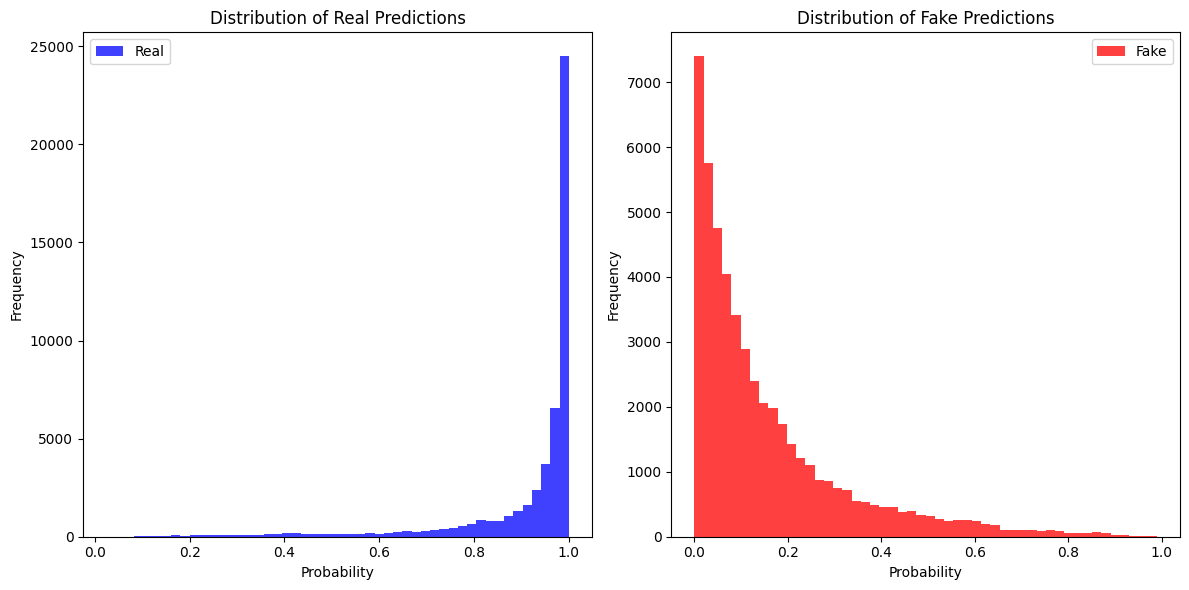


Fake label predictions:
Min: 1.758557846187614e-05
Max: 0.9898697733879089
Mean: 0.15686435997486115
Median: 0.09668020904064178

Real label predictions:
Min: 0.02423272654414177
Max: 1.0
Mean: 0.9164348244667053
Median: 0.9793847799301147


In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# preds가 리스트인 경우 numpy 배열로 변환
preds = np.array(final_pred_mean_reshaped)

# 예측값의 통계 정보 확인
print("Preds statistics:")
print(pd.DataFrame(preds).describe())

# NaN 값 확인
nan_mask = np.isnan(preds)
print("Number of NaN values:", np.sum(nan_mask))

# NaN 값을 0으로 대체 (또는 다른 적절한 값으로 대체 가능)
preds = np.nan_to_num(preds)

# 히스토그램으로 분포 시각화
plt.figure(figsize=(12, 6))

# Real 레이블의 분포
plt.subplot(1, 2, 1)
plt.hist(preds[:, 1], bins=50, alpha=0.75, color='blue', label='Real')
plt.title('Distribution of Real Predictions')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.legend()

# Fake 레이블의 분포
plt.subplot(1, 2, 2)
plt.hist(preds[:, 0], bins=50, alpha=0.75, color='red', label='Fake')
plt.title('Distribution of Fake Predictions')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()


# 가짜 음성을 분류하지 못하는지 확인
fake_preds = preds[:, 0]
real_preds = preds[:, 1]

# Fake 레이블에 대한 기본 통계 확인
print("\nFake label predictions:")
print(f"Min: {fake_preds.min()}")
print(f"Max: {fake_preds.max()}")
print(f"Mean: {fake_preds.mean()}")
print(f"Median: {np.median(fake_preds)}")

# Real 레이블에 대한 기본 통계 확인
print("\nReal label predictions:")
print(f"Min: {real_preds.min()}")
print(f"Max: {real_preds.max()}")
print(f"Mean: {real_preds.mean()}")
print(f"Median: {np.median(real_preds)}")


In [23]:
submit.iloc[:, 1:] = preds
submit.to_csv('0717_mels_mfcc_hamming_resCNN_5folds.csv', index=False)

In [22]:
!pip install torchinfo